### In this notebook, we will solve for ice flux and bedrock evolution because of flow of glacier under four different scenarios. Basic method entails discretizing the continuity equation and estimating each of its components at each node at each time step.

In [8]:
# Common things in each of the problems
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import time
%matplotlib inline

# constants
rho = 900.0; g = 9.8; A = 1.e-16; n = 3.
c = 0.03125 * (2 * A / (n + 2)) * (rho * g) ** n

#### 1. The first set of codes will solve the one dimensional flowline model using an explicit finite diff method and plot the final steady state.

0.0
50.0
100.0
150.0
200.0
250.0
300.0
350.0
400.0
450.0
500.0


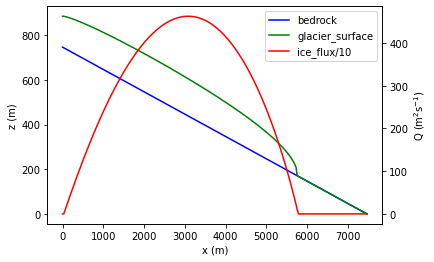

In [9]:
# geometry
dx = 30.; x_steps = 250; 
X = np.arange(x_steps) * dx # Total domain of the numerical scheme
dt = 0.002; t_steps = 250001;

# Initial geometry of the bed
s_bed = 0.1; z_bed = np.array([6000. - s_bed * dx * i for i in range(x_steps)])

# mass balance parameters
beta= 0.01; ela= 5860.

#initialisation. Initial state for ice thickness
h = np.zeros(x_steps)

# evolve profiles
for t in range(t_steps):
    z_ice = z_bed + h # compute ice surface
    m_b = - beta * (ela - z_ice) # compute surface mass balance
    s_ice = (z_ice[1:] - z_ice[:x_steps-1]) / dx # surface slope
    f_ice = -c * (s_ice ** 3) * (h[1:] + h[:x_steps-1]) ** 5 # ice fluxes
    h[1:x_steps-1] += (((f_ice[:x_steps-2] - f_ice[1:]) / dx) + m_b[1 : x_steps-1])*dt # update ice thickness
    # no-flux Boundary condition on top
    h[0] = h[1] - (s_bed * dx) 
    
    h.clip(min=0,out=h) # remove negative thickness values
    
    # type put a few time instances to check if the code is running or not
    if t % 25000 == 0:
        print(t * dt)
        
# plotting
fig, ax1 = plt.subplots()
ax1.plot(X, z_bed - z_bed[x_steps - 1], 'b-', label="bedrock")
ax1.plot(X, z_ice - z_bed[x_steps - 1], 'g-', label="glacier_surface")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)") 

ax2 = ax1.twinx()
ax2.plot(X, np.append([0], f_ice / 10),'r-',label = "ice_flux/10")
ax2.set_ylabel("Q (m$^2$s$^{-1}$)")

fig.legend(loc = 'upper right', bbox_to_anchor = (1, 1), bbox_transform = ax1.transAxes)

#### 2. In this second example, we will see hoe results across the transition between two steady states.

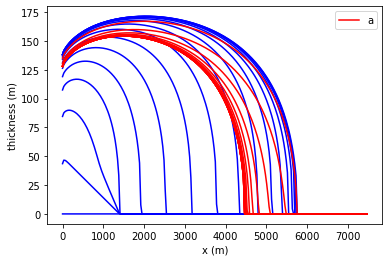

1000.0


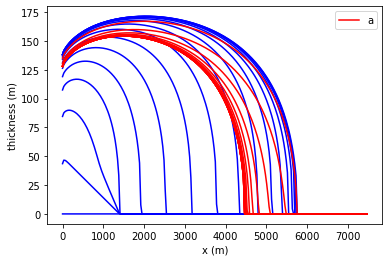

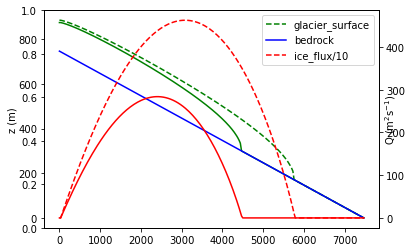

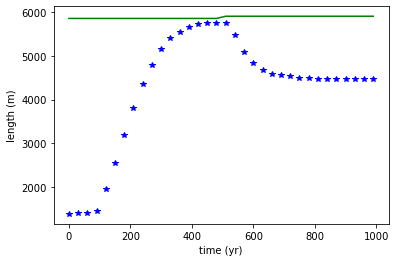

In [10]:
# geometry
dx = 30.; x_steps = 250; X = np.arange(x_steps) * dx
dt = 0.002; t_steps = 500001;
s_bed = 0.1; z_bed = np.array([6000.- s_bed * dx * i for i in range(x_steps)])
# mass balance parameters
beta = 0.01; ela = 5860.

# intialising storage and plots etc 
t_store = 15000; l = np.array([]); e = np.array([])
fig1 = plt.figure(1) 
ax1 = plt.gca()
ax2 = ax1.twinx()
plt.xlabel("x (m)")
ax1.set_ylabel("z (m)")
ax2.set_ylabel("Q (m$^2$s$^{-1}$)")
fig2 = plt.figure(2); plt.xlabel("x (m)"); plt.ylabel("thickness (m)")

# initialisation of ice thickness
h = np.array(np.zeros(x_steps))

# evolve profiles in time
n = 1 # Some counter
m = 1 # Some counter

for t in range(t_steps):
    z_ice = z_bed + h # compute ice surface
    m_b = -beta * (ela - z_ice) # compute surface mass balance
    s_ice = (z_ice[1:] - z_ice[:x_steps - 1]) / dx # surface slope
    f_ice = -c * (s_ice ** 3) * (h[1:] + h[:x_steps - 1]) ** 5 # ice fluxes
    h[1 : x_steps - 1] += ((f_ice[:x_steps - 2] - f_ice[1:]) / dx + m_b[1 : x_steps - 1]) * dt # update ice thickness
    h[0] = h[1] - s_bed * dx # no-flux BC on top
    h.clip(min = 0, out = h) # remove negative thickness values
    
    if t % 25000 == 0:
        print(t * dt)

    if (t == int(t_steps / 2)): # changing ELA halfway through
        ela += 50
        plt.figure(1) # plotting initial steady state
        ax1 = plt.gca()
        lns1 = ax1.plot(X, z_ice - z_bed[x_steps - 1], 'g--', label= "glacier_surface")
        ax2 = ax1.twinx()
        lns3 = ax2.plot(X, np.append([0], f_ice / 10), 'r--', label = "ice_flux/10")

    if(t % t_store == 0): # storing and plotting the intermediate profiles etd 
        l = np.append(l, np.count_nonzero(h)) 
        e = np.append(e, ela) 
        plt.figure(2)
        
        if(t < t_steps / 2): # with the first ELA
            l1 = plt.plot(X, h, 'b-') # plot intermediate profiles in blue
            # plt.pause(0.1) # Will be necesary if run in offline UI, such as Spyder. Doesn't work in Jupyter notebook.
            if n == 1:
                plt.legend(l1, 'before $t_{1/2}$')
            n += 1
            display.clear_output(wait = True)
            display.display(plt.gcf())
            time.sleep(0.1)
        else: # with the updated ELA
            l2 = plt.plot(X, h, 'r-') # plot intermediate profiles in red
            # plt.pause(0.1) 
            if m == 1:
                plt.legend(l2, 'after $t_{1/2}$')
            m += 1
            display.clear_output(wait = True)
            display.display(plt.gcf())
            time.sleep(0.1)
            
# final plotting
plt.figure(1);
ax1.plot(X, z_ice - z_bed[x_steps - 1], 'g-', label = "")
ax2.plot(X, np.append([0], f_ice / 10), 'r-', label= "")
lns2 = ax1.plot(X, z_bed - z_bed[x_steps - 1], 'b-', label = "bedrock")

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

plt.legend(lns, labs)

fig3 = plt.figure(3); plt.xlabel("time (yr)"); plt.ylabel("length (m)")
plt.plot(t_store * dt * (np.arange(l.size)), l * dx, 'b*')
plt.plot(t_store * dt * (np.arange(l.size)), e, 'g-')

#### 3. In the third example, we will also simulate the evolution of bedrock alongwith other results from previous examples. For that, we will make an assumotion that bedrock erosion is proportional to flux. To keep it simple, we will consider a constant ELA.

In [16]:
# The following function simply creates and stores the results as images at intermediate times.

def save_plot(outfolder):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("x (m)"); ax1.set_ylabel("z (m)")
    #plt.ylim(0,1200)
    lns1 = ax1.plot(np.arange(x_steps) * dx, z_bed - z_bed[x_steps - 1], 'b-', label = "bedrock")
    lns2 = ax1.plot(np.arange(x_steps) * dx, np.array([ela - z_bed[x_steps - 1]  for i in range(x_steps)]),
             'c--', label = "ELA")
    lns3 = ax1.plot(np.arange(x_steps) * dx, z_bed_ini - z_bed_ini[x_steps - 1], 'y--', label = "bedrock_ini")
    lns4 = ax1.plot(np.arange(x_steps) * dx, z_ice - z_bed[x_steps - 1], 'g-', label = "glacier_surface")
    
    ax2 = ax1.twinx()
    lns5 = ax2.plot(np.arange(x_steps) * dx, np.append([0], f_ice) / 2, 'r--', label = "ice_flux/2")
    ax2.set_ylabel("Q (m$^2$s$^{-1}$)")
    
    lns = lns1 + lns2 + lns3 + lns4 + lns5
    labs = [l.get_label() for l in lns]

    plt.legend(lns, labs)
    
    # Saving the result for each 1000 yrs of simulation
    if int(t * dt / 1000) < 10:
        plt.savefig(outfolder + "\\" + '0' + str(int(t*dt/1000)) + ".png") # linear
    else:
        plt.savefig(outfolder + "\\" + str(int(t*dt/1000)) + ".png") #linear
    plt.close()    # close the figure to show the next one.

# The outfolder has to be provided before starting to save the files# The outfolder has to be provided before starting to save the files
myDir = input("Select a folder to store the images for different time instances : ")

#constants
rho = 900.0; g = 9.8; A = 1.e-16; n = 3.
c= 0.03125 * (2 * A / (n + 2)) * (rho * g) ** n # for flux
c1 = 0.0001

# geometry
dx = 30.; x_steps = 200; x_max = x_steps * dx
dt = 0.01; t_wups = 5000002; t_steps = 0; t_max = t_steps * dt
s_bed = 0.1; z_bed = np.array([6000.- s_bed * dx * i for i in range(x_steps)])
z_bed_ini = z_bed

# initialisation (thickness and diffusivity)
h = np.array(np.zeros(x_steps))

# mass balance parameters
beta = 0.006
ela = 5900.

# evolve profiles
for t in range(t_wups):
    z_ice = z_bed + h # ice surface
    m_b = -beta * (ela - z_ice) # surface mass balance
    s_ice = (z_ice[1:] - z_ice[:x_steps - 1]) / dx # surface slope
    f_ice = -c * (s_ice ** 3) * (h[1:] + h[:x_steps - 1]) ** 5 # ice fluxes
    h[1 : x_steps - 1] += ((f_ice[:x_steps - 2] - f_ice[1:]) / dx + m_b[1 : x_steps - 1]) * dt # update ice thickness
    h[0] = h[1] - s_bed * dx # no-flux BC on top
    h.clip(min = 0, out = h) # remove negative thickness values
    
    #update bed every 10 years
    if(t % 1000 == 0):
        z_bed = z_bed - (c1 * np.append([0], f_ice))
    #save/display every 2000 years
    if(t % 200000 == 1):
        save_plot(outfolder = myDir)
        print(str(t) + ' done...')
        
# To join the images into an animation
from PIL import Image
import glob

frames = []
imgs = glob.glob(myDir + "\*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops
frames[0].save(myDir + '//' + 'png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000)        
        

Select a folder to store the images for different time instances : E:\IISER_PUNE\KU_workshop\flm.1
1 done...
200001 done...
400001 done...
600001 done...
800001 done...
1000001 done...
1200001 done...
1400001 done...
1600001 done...
1800001 done...
2000001 done...
2200001 done...
2400001 done...
2600001 done...
2800001 done...
3000001 done...
3200001 done...
3400001 done...
3600001 done...
3800001 done...
4000001 done...
4200001 done...
4400001 done...
4600001 done...
4800001 done...
5000001 done...


#### 4. In the last experiment, we will lower the ELA by 0.025 m every 10 yrs, while keeping other assumptions and model parameters same as previous example.

In [12]:
# The following function simply creates and stores the results as images at intermediate times.
def save_plot(outfolder):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("x (m)");ax1.set_ylabel("z (m)")
    lns1 = ax1.plot(np.arange(x_steps)*dx,z_bed-z_bed[x_steps-1],'b-',label="bedrock")
    lns2 = ax1.plot(np.arange(x_steps)*dx,np.array([ela-z_bed[x_steps-1]  for i in range(x_steps)]),
             'c--',label="ELA")
    lns3 = ax1.plot(np.arange(x_steps)*dx,z_bed_ini-z_bed_ini[x_steps-1],'y--',label="bedrock_ini")
    lns4 = ax1.plot(np.arange(x_steps)*dx,z_ice-z_bed[x_steps-1],'g-',label="glacier_surface")
    
    ax2 = ax1.twinx()
    lns5 = ax2.plot(np.arange(x_steps)*dx,np.append([0],f_ice)/2,'r--',label="ice_flux/2")
    ax2.set_ylabel("Q (m$^2$s$^{-1}$)")
    
    lns = lns1+lns2+lns3+lns4+lns5
    labs = [l.get_label() for l in lns]

    plt.legend(lns, labs)
    
    # Saving the result for each 1000 yrs of simulation
    if int(t*dt/1000) < 10:
        plt.savefig(outfolder+ "\\" + '0' + str(int(t*dt/1000))+".png")#linear
    else:
        plt.savefig(outfolder+ "\\" + str(int(t*dt/1000))+".png")#linear
    plt.close()    # close the figure to show the next one.
    
myDir = input("Select a folder to store the images for different time instances : ")

#constants
rho = 900.0; g = 9.8; A = 1.e-16; n = 3.
c= 0.03125 * (2 * A / (n + 2)) * (rho * g) ** n # for flux
c1 = 0.0001

# geometry
dx = 50.; x_steps = 150; x_max = x_steps * dx
dt = 0.01; t_wups = 5000002; t_steps = 0; t_max = t_steps * dt
s_bed = 0.1; z_bed = np.array([6000. - s_bed * dx * i for i in range(x_steps)])

# initialisation (thickness and diffusivity)
h = np.array(np.zeros(x_steps))
h[:100] = 100 * np.sin(np.pi * np.arange(100) / 100.)

# mass balance parameters
beta = 0.006
ela = 5900.
z_bed_ini = z_bed

for t in range(t_wups): # evolve profiles
    z_ice = z_bed + h # ice surface
    m_b = -beta * (ela - z_ice) # surface mass balance
    s_ice = (z_ice[1:] - z_ice[:x_steps - 1]) / dx # surface slope
    f_ice = -c * (s_ice ** 3) * (h[1:] + h[:x_steps - 1]) ** 5 # ice fluxes
    h[1 : x_steps - 1] += ((f_ice[:x_steps - 2] - f_ice[1:]) / dx + m_b[1 : x_steps - 1]) *dt # update ice thickness
    h[0] = h[1] - s_bed * dx # no-flux BC on top
    h.clip(min = 0, out = h) # remove negative thickness values

    if(t % 1000 == 0): #update bed every 10 years
        z_bed = z_bed - (c1 * np.append([0], f_ice))
        ela = ela - 0.025
        #ela= ela +  np.sin(t)

    if(t % 100000 == 1): #save every 5000 years
        save_plot(outfolder=myDir)
        print(str(t) + ' is done....')
print('done')

#%% Combining the .png files into one gif file
from PIL import Image
import glob

frames = []
imgs = glob.glob(myDir + "\*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save(myDir + '//' + 'png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000)

1 is done....
100001 is done....
200001 is done....
300001 is done....
400001 is done....
500001 is done....
600001 is done....
700001 is done....
800001 is done....
900001 is done....
1000001 is done....
1100001 is done....
1200001 is done....
1300001 is done....
1400001 is done....
1500001 is done....
1600001 is done....
1700001 is done....
1800001 is done....
1900001 is done....
2000001 is done....
2100001 is done....
2200001 is done....
2300001 is done....
2400001 is done....
2500001 is done....
2600001 is done....
2700001 is done....
2800001 is done....
2900001 is done....
3000001 is done....
3100001 is done....
3200001 is done....
3300001 is done....
3400001 is done....
3500001 is done....
3600001 is done....
3700001 is done....
3800001 is done....
3900001 is done....
4000001 is done....
4100001 is done....
4200001 is done....
4300001 is done....
4400001 is done....
4500001 is done....
4600001 is done....
4700001 is done....
4800001 is done....
4900001 is done....
5000001 is done

### Print dependencies (for reuirements.txt file for binder)

In [14]:
%load_ext watermark

%watermark -v -m -p numpy,matplotlib,PIL,time,tkinter,glob,watermark

print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy     : 1.20.3
matplotlib: 3.3.4
PIL       : 8.3.1
time      : unknown
tkinter   : unknown
glob      : unknown
watermark : 2.2.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 69 Stepping 1, GenuineIntel
CPU cores   : 4
Architecture: 64bit

 
Last updated: Sun Aug 01 2021 00:57:12Pacific Daylight Time



In [15]:
%watermark --iversions

PIL       : 8.3.1
matplotlib: 3.3.4
IPython   : 7.22.0
numpy     : 1.20.3

